# [EX19] Segmentation map으로 도로 이미지 만들기

#### * 목차
1. 데이터 준비하기        
 1) augmentation 적용     
2. Generator 구현    
3. Discriminator 구현         
4. 모델 학습    
5. 모델 테스트    
6. 결과    

## 1. 데이터 준비하기

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


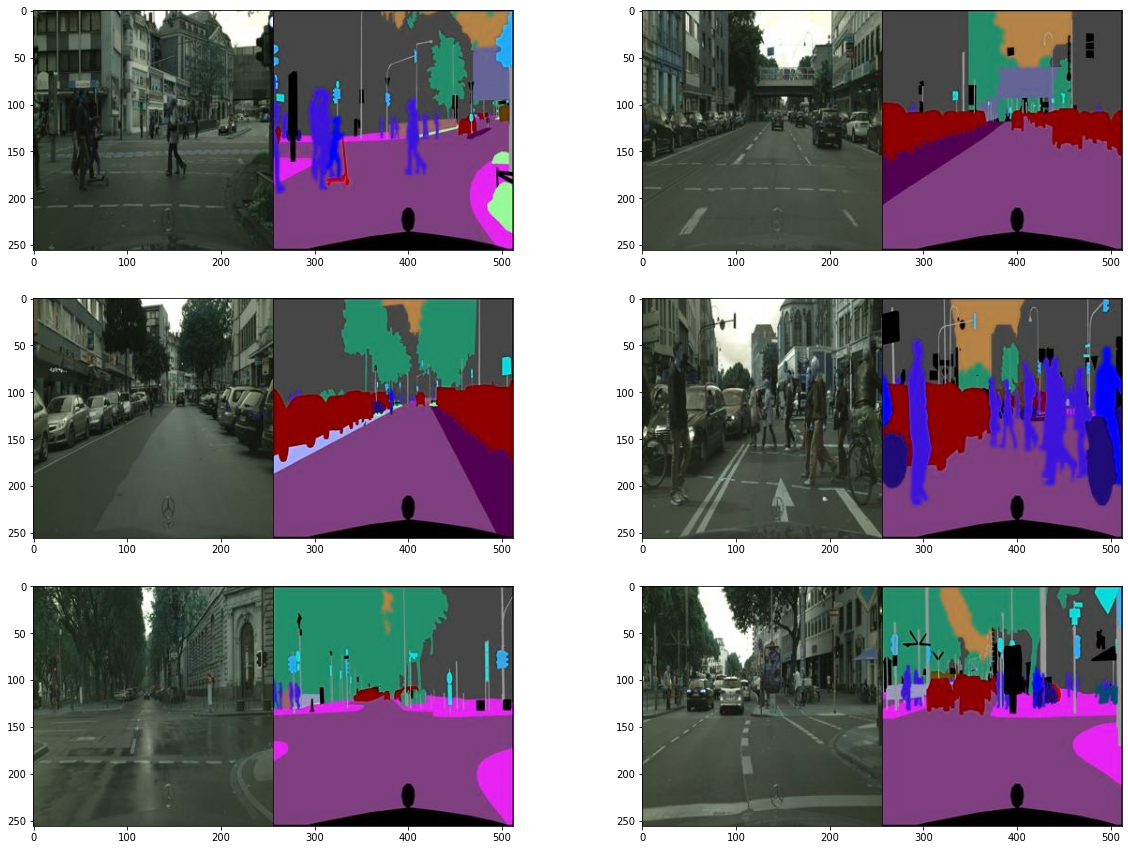

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


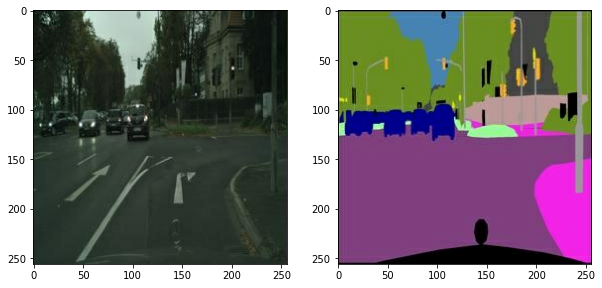

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

### 1) augmentation 적용

In [22]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)                          # 1
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])                              # 2
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])                      # 3
    
    out = image.random_flip_left_right(out)                                  # 4
    out = image.random_flip_up_down(out)                                     # 5
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)                                     # 6
    
    return out[...,:3], out[...,3:]  

###  apply_augmentation 함수 코드 설명
* 위 함수에 두 이미지가 입력되었을때 발생 과정 순서
1. 두 이미지가 채널 축으로 연결. 두 이미지가 각각 3채널인 경우 6채널이 된다.    
2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용된다.      
3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라낸다.      
4. 3.의 결과를 50% 확률로 가로로 뒤집는다.
5. 4.의 결과를 50% 확률로 세로로 뒤집는다.
6. 5.의 결과를 50% 확률로 회전시킨다.

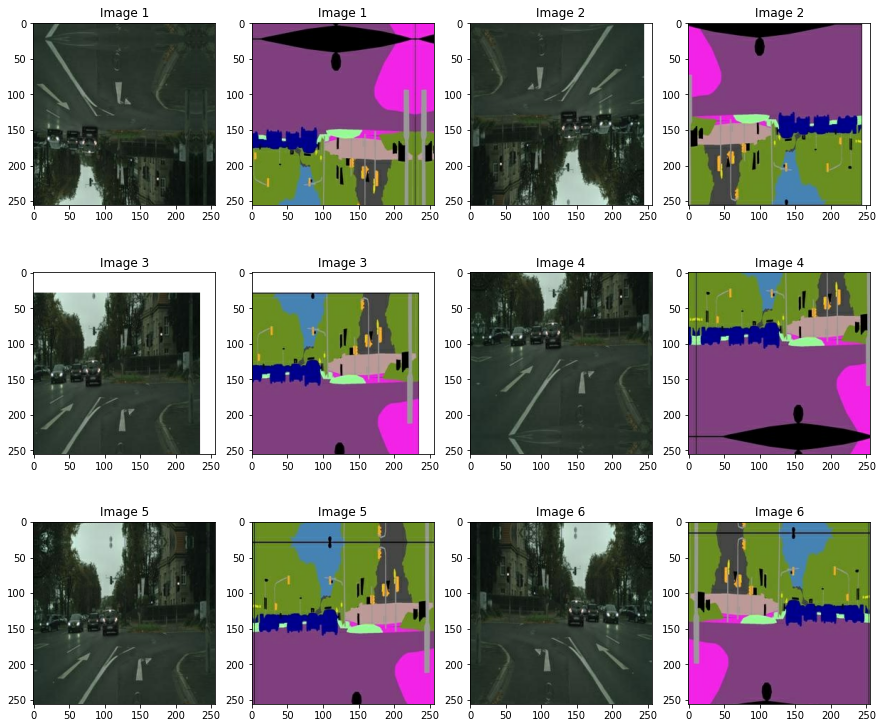

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

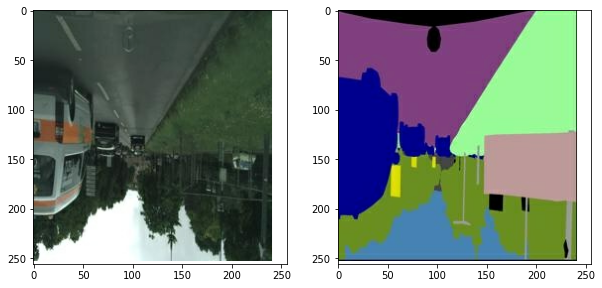

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 2. Generator 구현

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 3. Discriminator 구현

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [13]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [15]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

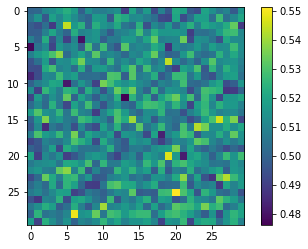

In [16]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 4. 모델 학습 

In [17]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [18]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [19]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [20]:
EPOCHS = 100 #약 300분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9839                     
L1_loss:0.3159                     
Discriminator_loss:1.3610

EPOCH[1] - STEP[20]                     
Generator_loss:1.1029                     
L1_loss:0.3152                     
Discriminator_loss:1.2544

EPOCH[1] - STEP[30]                     
Generator_loss:1.1147                     
L1_loss:0.3162                     
Discriminator_loss:1.0764

EPOCH[1] - STEP[40]                     
Generator_loss:1.4344                     
L1_loss:0.3208                     
Discriminator_loss:0.5991

EPOCH[1] - STEP[50]                     
Generator_loss:2.0086                     
L1_loss:0.2484                     
Discriminator_loss:0.4244

EPOCH[1] - STEP[60]                     
Generator_loss:2.2200                     
L1_loss:0.2348                     
Discriminator_loss:0.4248

EPOCH[1] - STEP[70]                     
Generator_loss:1.8222                     
L1_loss:0.2869                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.7649                     
L1_loss:0.2210                     
Discriminator_loss:0.5396

EPOCH[3] - STEP[80]                     
Generator_loss:1.9201                     
L1_loss:0.2200                     
Discriminator_loss:0.6845

EPOCH[3] - STEP[90]                     
Generator_loss:1.9545                     
L1_loss:0.1766                     
Discriminator_loss:0.7845

EPOCH[3] - STEP[100]                     
Generator_loss:1.1105                     
L1_loss:0.2320                     
Discriminator_loss:0.6989

EPOCH[3] - STEP[110]                     
Generator_loss:2.8905                     
L1_loss:0.2049                     
Discriminator_loss:1.2425

EPOCH[3] - STEP[120]                     
Generator_loss:3.0699                     
L1_loss:0.2137                     
Discriminator_loss:0.6613

EPOCH[3] - STEP[130]                     
Generator_loss:2.6410                     
L1_loss:0.1555                

EPOCH[5] - STEP[130]                     
Generator_loss:0.9919                     
L1_loss:0.2067                     
Discriminator_loss:0.8875

EPOCH[5] - STEP[140]                     
Generator_loss:1.3031                     
L1_loss:0.1920                     
Discriminator_loss:0.8812

EPOCH[5] - STEP[150]                     
Generator_loss:2.3614                     
L1_loss:0.1661                     
Discriminator_loss:0.8984

EPOCH[5] - STEP[160]                     
Generator_loss:1.7355                     
L1_loss:0.2235                     
Discriminator_loss:0.4425

EPOCH[5] - STEP[170]                     
Generator_loss:0.8470                     
L1_loss:0.1950                     
Discriminator_loss:0.9378

EPOCH[5] - STEP[180]                     
Generator_loss:1.9748                     
L1_loss:0.1786                     
Discriminator_loss:0.6054

EPOCH[5] - STEP[190]                     
Generator_loss:0.7640                     
L1_loss:0.2174             

EPOCH[7] - STEP[190]                     
Generator_loss:1.9143                     
L1_loss:0.1831                     
Discriminator_loss:0.5208

EPOCH[7] - STEP[200]                     
Generator_loss:1.5861                     
L1_loss:0.2073                     
Discriminator_loss:0.5207

EPOCH[7] - STEP[210]                     
Generator_loss:2.1748                     
L1_loss:0.1954                     
Discriminator_loss:0.8598

EPOCH[7] - STEP[220]                     
Generator_loss:0.4157                     
L1_loss:0.1845                     
Discriminator_loss:1.4629

EPOCH[7] - STEP[230]                     
Generator_loss:1.1213                     
L1_loss:0.1802                     
Discriminator_loss:0.5429

EPOCH[7] - STEP[240]                     
Generator_loss:2.2191                     
L1_loss:0.1885                     
Discriminator_loss:0.3725

EPOCH[7] - STEP[250]                     
Generator_loss:2.6820                     
L1_loss:0.1798             

EPOCH[9] - STEP[250]                     
Generator_loss:1.9318                     
L1_loss:0.1462                     
Discriminator_loss:0.4333

EPOCH[10] - STEP[10]                     
Generator_loss:2.5511                     
L1_loss:0.1709                     
Discriminator_loss:0.8340

EPOCH[10] - STEP[20]                     
Generator_loss:2.1821                     
L1_loss:0.2202                     
Discriminator_loss:0.8053

EPOCH[10] - STEP[30]                     
Generator_loss:1.9569                     
L1_loss:0.2023                     
Discriminator_loss:0.3175

EPOCH[10] - STEP[40]                     
Generator_loss:2.3730                     
L1_loss:0.1933                     
Discriminator_loss:0.7323

EPOCH[10] - STEP[50]                     
Generator_loss:0.9007                     
L1_loss:0.2293                     
Discriminator_loss:0.8443

EPOCH[10] - STEP[60]                     
Generator_loss:2.5272                     
L1_loss:0.1806             

EPOCH[12] - STEP[60]                     
Generator_loss:1.7947                     
L1_loss:0.1874                     
Discriminator_loss:0.4343

EPOCH[12] - STEP[70]                     
Generator_loss:2.4499                     
L1_loss:0.1890                     
Discriminator_loss:0.4399

EPOCH[12] - STEP[80]                     
Generator_loss:0.8469                     
L1_loss:0.1722                     
Discriminator_loss:0.7854

EPOCH[12] - STEP[90]                     
Generator_loss:2.1378                     
L1_loss:0.2090                     
Discriminator_loss:0.6652

EPOCH[12] - STEP[100]                     
Generator_loss:2.4572                     
L1_loss:0.1602                     
Discriminator_loss:1.0084

EPOCH[12] - STEP[110]                     
Generator_loss:1.8603                     
L1_loss:0.1882                     
Discriminator_loss:0.4329

EPOCH[12] - STEP[120]                     
Generator_loss:0.7990                     
L1_loss:0.1861          

EPOCH[14] - STEP[120]                     
Generator_loss:1.9545                     
L1_loss:0.1716                     
Discriminator_loss:0.3491

EPOCH[14] - STEP[130]                     
Generator_loss:1.6907                     
L1_loss:0.1587                     
Discriminator_loss:0.7465

EPOCH[14] - STEP[140]                     
Generator_loss:1.7545                     
L1_loss:0.1481                     
Discriminator_loss:0.6218

EPOCH[14] - STEP[150]                     
Generator_loss:1.4837                     
L1_loss:0.1390                     
Discriminator_loss:0.8020

EPOCH[14] - STEP[160]                     
Generator_loss:1.0078                     
L1_loss:0.1392                     
Discriminator_loss:0.7149

EPOCH[14] - STEP[170]                     
Generator_loss:0.8404                     
L1_loss:0.1405                     
Discriminator_loss:1.0396

EPOCH[14] - STEP[180]                     
Generator_loss:1.7115                     
L1_loss:0.1609      

EPOCH[16] - STEP[180]                     
Generator_loss:1.3516                     
L1_loss:0.2059                     
Discriminator_loss:0.5039

EPOCH[16] - STEP[190]                     
Generator_loss:1.5920                     
L1_loss:0.1685                     
Discriminator_loss:0.5841

EPOCH[16] - STEP[200]                     
Generator_loss:3.0828                     
L1_loss:0.1600                     
Discriminator_loss:0.2801

EPOCH[16] - STEP[210]                     
Generator_loss:3.8398                     
L1_loss:0.1771                     
Discriminator_loss:1.2169

EPOCH[16] - STEP[220]                     
Generator_loss:2.3862                     
L1_loss:0.1942                     
Discriminator_loss:0.7119

EPOCH[16] - STEP[230]                     
Generator_loss:2.4165                     
L1_loss:0.1810                     
Discriminator_loss:0.4955

EPOCH[16] - STEP[240]                     
Generator_loss:1.9538                     
L1_loss:0.1597      

EPOCH[18] - STEP[240]                     
Generator_loss:0.6464                     
L1_loss:0.1771                     
Discriminator_loss:0.9716

EPOCH[18] - STEP[250]                     
Generator_loss:2.4198                     
L1_loss:0.1349                     
Discriminator_loss:0.9777

EPOCH[19] - STEP[10]                     
Generator_loss:2.6935                     
L1_loss:0.1773                     
Discriminator_loss:0.1873

EPOCH[19] - STEP[20]                     
Generator_loss:1.9795                     
L1_loss:0.1757                     
Discriminator_loss:0.6349

EPOCH[19] - STEP[30]                     
Generator_loss:2.3310                     
L1_loss:0.1255                     
Discriminator_loss:1.4770

EPOCH[19] - STEP[40]                     
Generator_loss:1.3555                     
L1_loss:0.1741                     
Discriminator_loss:0.5517

EPOCH[19] - STEP[50]                     
Generator_loss:1.6842                     
L1_loss:0.1769           

EPOCH[21] - STEP[50]                     
Generator_loss:1.3780                     
L1_loss:0.1881                     
Discriminator_loss:0.8247

EPOCH[21] - STEP[60]                     
Generator_loss:0.9923                     
L1_loss:0.1481                     
Discriminator_loss:0.7142

EPOCH[21] - STEP[70]                     
Generator_loss:1.1336                     
L1_loss:0.1699                     
Discriminator_loss:0.5627

EPOCH[21] - STEP[80]                     
Generator_loss:0.7097                     
L1_loss:0.1316                     
Discriminator_loss:1.2364

EPOCH[21] - STEP[90]                     
Generator_loss:1.8288                     
L1_loss:0.1785                     
Discriminator_loss:0.2683

EPOCH[21] - STEP[100]                     
Generator_loss:1.7121                     
L1_loss:0.1933                     
Discriminator_loss:0.7162

EPOCH[21] - STEP[110]                     
Generator_loss:1.2812                     
L1_loss:0.1363           

EPOCH[23] - STEP[110]                     
Generator_loss:2.1068                     
L1_loss:0.1852                     
Discriminator_loss:0.7607

EPOCH[23] - STEP[120]                     
Generator_loss:1.1708                     
L1_loss:0.1354                     
Discriminator_loss:0.5735

EPOCH[23] - STEP[130]                     
Generator_loss:0.9854                     
L1_loss:0.2029                     
Discriminator_loss:0.6637

EPOCH[23] - STEP[140]                     
Generator_loss:0.5360                     
L1_loss:0.1699                     
Discriminator_loss:1.1842

EPOCH[23] - STEP[150]                     
Generator_loss:2.0165                     
L1_loss:0.1309                     
Discriminator_loss:0.9011

EPOCH[23] - STEP[160]                     
Generator_loss:1.2797                     
L1_loss:0.1534                     
Discriminator_loss:0.8842

EPOCH[23] - STEP[170]                     
Generator_loss:2.8276                     
L1_loss:0.1534      

EPOCH[25] - STEP[170]                     
Generator_loss:1.6129                     
L1_loss:0.1507                     
Discriminator_loss:0.3994

EPOCH[25] - STEP[180]                     
Generator_loss:3.0948                     
L1_loss:0.1548                     
Discriminator_loss:0.1268

EPOCH[25] - STEP[190]                     
Generator_loss:2.7243                     
L1_loss:0.1411                     
Discriminator_loss:0.4981

EPOCH[25] - STEP[200]                     
Generator_loss:1.5190                     
L1_loss:0.1337                     
Discriminator_loss:0.9904

EPOCH[25] - STEP[210]                     
Generator_loss:2.2245                     
L1_loss:0.1456                     
Discriminator_loss:0.3470

EPOCH[25] - STEP[220]                     
Generator_loss:2.7573                     
L1_loss:0.1426                     
Discriminator_loss:0.3728

EPOCH[25] - STEP[230]                     
Generator_loss:0.3092                     
L1_loss:0.1757      

EPOCH[27] - STEP[230]                     
Generator_loss:0.6112                     
L1_loss:0.1458                     
Discriminator_loss:1.2306

EPOCH[27] - STEP[240]                     
Generator_loss:0.9319                     
L1_loss:0.1558                     
Discriminator_loss:0.6903

EPOCH[27] - STEP[250]                     
Generator_loss:1.8956                     
L1_loss:0.2014                     
Discriminator_loss:0.2697

EPOCH[28] - STEP[10]                     
Generator_loss:2.7856                     
L1_loss:0.1684                     
Discriminator_loss:0.3662

EPOCH[28] - STEP[20]                     
Generator_loss:0.6008                     
L1_loss:0.1675                     
Discriminator_loss:1.1369

EPOCH[28] - STEP[30]                     
Generator_loss:0.7385                     
L1_loss:0.1333                     
Discriminator_loss:1.1921

EPOCH[28] - STEP[40]                     
Generator_loss:1.0279                     
L1_loss:0.1386          

EPOCH[30] - STEP[40]                     
Generator_loss:2.4823                     
L1_loss:0.1413                     
Discriminator_loss:0.4309

EPOCH[30] - STEP[50]                     
Generator_loss:1.0261                     
L1_loss:0.1407                     
Discriminator_loss:0.8424

EPOCH[30] - STEP[60]                     
Generator_loss:2.6544                     
L1_loss:0.1727                     
Discriminator_loss:0.5726

EPOCH[30] - STEP[70]                     
Generator_loss:3.5438                     
L1_loss:0.1322                     
Discriminator_loss:1.1381

EPOCH[30] - STEP[80]                     
Generator_loss:1.5769                     
L1_loss:0.1650                     
Discriminator_loss:0.5471

EPOCH[30] - STEP[90]                     
Generator_loss:1.3141                     
L1_loss:0.1705                     
Discriminator_loss:0.4996

EPOCH[30] - STEP[100]                     
Generator_loss:1.3897                     
L1_loss:0.1691            

EPOCH[32] - STEP[100]                     
Generator_loss:2.5885                     
L1_loss:0.2116                     
Discriminator_loss:0.2459

EPOCH[32] - STEP[110]                     
Generator_loss:3.4191                     
L1_loss:0.1514                     
Discriminator_loss:0.3474

EPOCH[32] - STEP[120]                     
Generator_loss:2.1796                     
L1_loss:0.1491                     
Discriminator_loss:0.4479

EPOCH[32] - STEP[130]                     
Generator_loss:1.2423                     
L1_loss:0.1469                     
Discriminator_loss:1.4930

EPOCH[32] - STEP[140]                     
Generator_loss:1.4310                     
L1_loss:0.1365                     
Discriminator_loss:0.4174

EPOCH[32] - STEP[150]                     
Generator_loss:1.7982                     
L1_loss:0.1522                     
Discriminator_loss:0.2967

EPOCH[32] - STEP[160]                     
Generator_loss:2.9587                     
L1_loss:0.1381      

EPOCH[34] - STEP[160]                     
Generator_loss:1.3191                     
L1_loss:0.1454                     
Discriminator_loss:0.7994

EPOCH[34] - STEP[170]                     
Generator_loss:3.8156                     
L1_loss:0.1438                     
Discriminator_loss:0.1400

EPOCH[34] - STEP[180]                     
Generator_loss:1.6522                     
L1_loss:0.1688                     
Discriminator_loss:0.4047

EPOCH[34] - STEP[190]                     
Generator_loss:3.9086                     
L1_loss:0.1517                     
Discriminator_loss:0.6188

EPOCH[34] - STEP[200]                     
Generator_loss:3.6889                     
L1_loss:0.1318                     
Discriminator_loss:1.0988

EPOCH[34] - STEP[210]                     
Generator_loss:1.8384                     
L1_loss:0.1420                     
Discriminator_loss:0.9131

EPOCH[34] - STEP[220]                     
Generator_loss:2.5782                     
L1_loss:0.1483      

EPOCH[36] - STEP[220]                     
Generator_loss:2.7120                     
L1_loss:0.2080                     
Discriminator_loss:0.1618

EPOCH[36] - STEP[230]                     
Generator_loss:2.7538                     
L1_loss:0.1512                     
Discriminator_loss:0.2362

EPOCH[36] - STEP[240]                     
Generator_loss:2.1127                     
L1_loss:0.1474                     
Discriminator_loss:0.3570

EPOCH[36] - STEP[250]                     
Generator_loss:4.5020                     
L1_loss:0.1594                     
Discriminator_loss:1.2158

EPOCH[37] - STEP[10]                     
Generator_loss:3.8162                     
L1_loss:0.1418                     
Discriminator_loss:0.6511

EPOCH[37] - STEP[20]                     
Generator_loss:2.1683                     
L1_loss:0.1619                     
Discriminator_loss:0.2396

EPOCH[37] - STEP[30]                     
Generator_loss:3.2217                     
L1_loss:0.1193         

EPOCH[39] - STEP[30]                     
Generator_loss:3.5825                     
L1_loss:0.1636                     
Discriminator_loss:0.1701

EPOCH[39] - STEP[40]                     
Generator_loss:3.7915                     
L1_loss:0.1421                     
Discriminator_loss:1.3161

EPOCH[39] - STEP[50]                     
Generator_loss:1.6857                     
L1_loss:0.1655                     
Discriminator_loss:0.3223

EPOCH[39] - STEP[60]                     
Generator_loss:0.1383                     
L1_loss:0.1555                     
Discriminator_loss:2.5856

EPOCH[39] - STEP[70]                     
Generator_loss:3.0254                     
L1_loss:0.1678                     
Discriminator_loss:0.2874

EPOCH[39] - STEP[80]                     
Generator_loss:0.9644                     
L1_loss:0.1261                     
Discriminator_loss:1.0895

EPOCH[39] - STEP[90]                     
Generator_loss:2.5812                     
L1_loss:0.1223             

EPOCH[41] - STEP[90]                     
Generator_loss:0.5312                     
L1_loss:0.1251                     
Discriminator_loss:1.7511

EPOCH[41] - STEP[100]                     
Generator_loss:2.8650                     
L1_loss:0.1411                     
Discriminator_loss:0.6698

EPOCH[41] - STEP[110]                     
Generator_loss:3.4201                     
L1_loss:0.1940                     
Discriminator_loss:0.0676

EPOCH[41] - STEP[120]                     
Generator_loss:1.6379                     
L1_loss:0.1262                     
Discriminator_loss:0.3481

EPOCH[41] - STEP[130]                     
Generator_loss:1.5291                     
L1_loss:0.1460                     
Discriminator_loss:0.7970

EPOCH[41] - STEP[140]                     
Generator_loss:0.6614                     
L1_loss:0.1729                     
Discriminator_loss:1.0856

EPOCH[41] - STEP[150]                     
Generator_loss:3.4340                     
L1_loss:0.1873       

EPOCH[43] - STEP[150]                     
Generator_loss:2.9614                     
L1_loss:0.1601                     
Discriminator_loss:0.2778

EPOCH[43] - STEP[160]                     
Generator_loss:1.4978                     
L1_loss:0.1664                     
Discriminator_loss:0.4183

EPOCH[43] - STEP[170]                     
Generator_loss:1.4293                     
L1_loss:0.1220                     
Discriminator_loss:0.8242

EPOCH[43] - STEP[180]                     
Generator_loss:1.6751                     
L1_loss:0.1714                     
Discriminator_loss:0.3474

EPOCH[43] - STEP[190]                     
Generator_loss:2.3231                     
L1_loss:0.1436                     
Discriminator_loss:0.2228

EPOCH[43] - STEP[200]                     
Generator_loss:5.3367                     
L1_loss:0.1616                     
Discriminator_loss:0.1392

EPOCH[43] - STEP[210]                     
Generator_loss:2.7357                     
L1_loss:0.1564      

EPOCH[45] - STEP[210]                     
Generator_loss:1.8094                     
L1_loss:0.2237                     
Discriminator_loss:0.3497

EPOCH[45] - STEP[220]                     
Generator_loss:3.4833                     
L1_loss:0.1411                     
Discriminator_loss:0.7878

EPOCH[45] - STEP[230]                     
Generator_loss:2.6861                     
L1_loss:0.1381                     
Discriminator_loss:0.2167

EPOCH[45] - STEP[240]                     
Generator_loss:4.9933                     
L1_loss:0.1791                     
Discriminator_loss:0.1581

EPOCH[45] - STEP[250]                     
Generator_loss:3.2345                     
L1_loss:0.1187                     
Discriminator_loss:1.2440

EPOCH[46] - STEP[10]                     
Generator_loss:2.3092                     
L1_loss:0.0999                     
Discriminator_loss:0.7697

EPOCH[46] - STEP[20]                     
Generator_loss:4.0169                     
L1_loss:0.2085        

EPOCH[48] - STEP[20]                     
Generator_loss:3.5227                     
L1_loss:0.1743                     
Discriminator_loss:0.2293

EPOCH[48] - STEP[30]                     
Generator_loss:2.3846                     
L1_loss:0.1392                     
Discriminator_loss:0.4671

EPOCH[48] - STEP[40]                     
Generator_loss:3.2765                     
L1_loss:0.1283                     
Discriminator_loss:1.6197

EPOCH[48] - STEP[50]                     
Generator_loss:1.0211                     
L1_loss:0.1447                     
Discriminator_loss:1.4555

EPOCH[48] - STEP[60]                     
Generator_loss:1.5164                     
L1_loss:0.1913                     
Discriminator_loss:0.6184

EPOCH[48] - STEP[70]                     
Generator_loss:1.4579                     
L1_loss:0.1569                     
Discriminator_loss:1.0115

EPOCH[48] - STEP[80]                     
Generator_loss:2.3827                     
L1_loss:0.1355             

EPOCH[50] - STEP[80]                     
Generator_loss:3.1722                     
L1_loss:0.1269                     
Discriminator_loss:1.8201

EPOCH[50] - STEP[90]                     
Generator_loss:2.1313                     
L1_loss:0.1490                     
Discriminator_loss:0.2424

EPOCH[50] - STEP[100]                     
Generator_loss:1.3100                     
L1_loss:0.1987                     
Discriminator_loss:0.5903

EPOCH[50] - STEP[110]                     
Generator_loss:2.4287                     
L1_loss:0.1469                     
Discriminator_loss:0.1946

EPOCH[50] - STEP[120]                     
Generator_loss:3.6862                     
L1_loss:0.1544                     
Discriminator_loss:1.2319

EPOCH[50] - STEP[130]                     
Generator_loss:2.2037                     
L1_loss:0.1411                     
Discriminator_loss:0.5505

EPOCH[50] - STEP[140]                     
Generator_loss:1.4272                     
L1_loss:0.1005        

EPOCH[52] - STEP[140]                     
Generator_loss:1.6636                     
L1_loss:0.1859                     
Discriminator_loss:0.4241

EPOCH[52] - STEP[150]                     
Generator_loss:3.9731                     
L1_loss:0.1221                     
Discriminator_loss:0.9986

EPOCH[52] - STEP[160]                     
Generator_loss:4.0401                     
L1_loss:0.1368                     
Discriminator_loss:0.3157

EPOCH[52] - STEP[170]                     
Generator_loss:0.4435                     
L1_loss:0.1549                     
Discriminator_loss:1.5138

EPOCH[52] - STEP[180]                     
Generator_loss:0.6345                     
L1_loss:0.1344                     
Discriminator_loss:1.0939

EPOCH[52] - STEP[190]                     
Generator_loss:3.2334                     
L1_loss:0.1791                     
Discriminator_loss:0.1745

EPOCH[52] - STEP[200]                     
Generator_loss:1.9779                     
L1_loss:0.1332      

EPOCH[54] - STEP[200]                     
Generator_loss:1.9438                     
L1_loss:0.1472                     
Discriminator_loss:0.3418

EPOCH[54] - STEP[210]                     
Generator_loss:2.4003                     
L1_loss:0.1240                     
Discriminator_loss:0.5060

EPOCH[54] - STEP[220]                     
Generator_loss:1.9271                     
L1_loss:0.1728                     
Discriminator_loss:0.3126

EPOCH[54] - STEP[230]                     
Generator_loss:1.0161                     
L1_loss:0.1296                     
Discriminator_loss:0.6184

EPOCH[54] - STEP[240]                     
Generator_loss:2.1008                     
L1_loss:0.1544                     
Discriminator_loss:0.6095

EPOCH[54] - STEP[250]                     
Generator_loss:1.9774                     
L1_loss:0.1379                     
Discriminator_loss:0.7003

EPOCH[55] - STEP[10]                     
Generator_loss:1.3267                     
L1_loss:0.1276       

EPOCH[57] - STEP[10]                     
Generator_loss:1.1374                     
L1_loss:0.1774                     
Discriminator_loss:0.8044

EPOCH[57] - STEP[20]                     
Generator_loss:3.2196                     
L1_loss:0.1328                     
Discriminator_loss:1.3050

EPOCH[57] - STEP[30]                     
Generator_loss:1.9689                     
L1_loss:0.1653                     
Discriminator_loss:0.2753

EPOCH[57] - STEP[40]                     
Generator_loss:0.9606                     
L1_loss:0.1179                     
Discriminator_loss:1.1096

EPOCH[57] - STEP[50]                     
Generator_loss:3.1399                     
L1_loss:0.1295                     
Discriminator_loss:0.6571

EPOCH[57] - STEP[60]                     
Generator_loss:3.6759                     
L1_loss:0.1502                     
Discriminator_loss:0.0772

EPOCH[57] - STEP[70]                     
Generator_loss:1.1391                     
L1_loss:0.1358             

EPOCH[59] - STEP[70]                     
Generator_loss:2.2539                     
L1_loss:0.1572                     
Discriminator_loss:0.1951

EPOCH[59] - STEP[80]                     
Generator_loss:1.6233                     
L1_loss:0.1442                     
Discriminator_loss:0.4913

EPOCH[59] - STEP[90]                     
Generator_loss:3.2348                     
L1_loss:0.1397                     
Discriminator_loss:1.3399

EPOCH[59] - STEP[100]                     
Generator_loss:2.6311                     
L1_loss:0.1356                     
Discriminator_loss:0.2531

EPOCH[59] - STEP[110]                     
Generator_loss:0.9178                     
L1_loss:0.1359                     
Discriminator_loss:0.9799

EPOCH[59] - STEP[120]                     
Generator_loss:2.9020                     
L1_loss:0.1662                     
Discriminator_loss:0.1048

EPOCH[59] - STEP[130]                     
Generator_loss:3.4155                     
L1_loss:0.1127         

EPOCH[61] - STEP[130]                     
Generator_loss:2.7461                     
L1_loss:0.1538                     
Discriminator_loss:0.2239

EPOCH[61] - STEP[140]                     
Generator_loss:0.4592                     
L1_loss:0.1447                     
Discriminator_loss:1.5324

EPOCH[61] - STEP[150]                     
Generator_loss:2.2740                     
L1_loss:0.1648                     
Discriminator_loss:0.2745

EPOCH[61] - STEP[160]                     
Generator_loss:2.8429                     
L1_loss:0.1574                     
Discriminator_loss:0.1210

EPOCH[61] - STEP[170]                     
Generator_loss:1.0483                     
L1_loss:0.1180                     
Discriminator_loss:0.7073

EPOCH[61] - STEP[180]                     
Generator_loss:1.4701                     
L1_loss:0.1565                     
Discriminator_loss:0.6306

EPOCH[61] - STEP[190]                     
Generator_loss:2.1253                     
L1_loss:0.1316      

EPOCH[63] - STEP[190]                     
Generator_loss:4.8508                     
L1_loss:0.1510                     
Discriminator_loss:0.0762

EPOCH[63] - STEP[200]                     
Generator_loss:3.7222                     
L1_loss:0.1370                     
Discriminator_loss:0.4523

EPOCH[63] - STEP[210]                     
Generator_loss:2.3310                     
L1_loss:0.1694                     
Discriminator_loss:0.1850

EPOCH[63] - STEP[220]                     
Generator_loss:3.1578                     
L1_loss:0.1579                     
Discriminator_loss:0.1539

EPOCH[63] - STEP[230]                     
Generator_loss:4.1140                     
L1_loss:0.1308                     
Discriminator_loss:1.1347

EPOCH[63] - STEP[240]                     
Generator_loss:3.1254                     
L1_loss:0.1434                     
Discriminator_loss:0.2346

EPOCH[63] - STEP[250]                     
Generator_loss:1.0731                     
L1_loss:0.1432      

EPOCH[65] - STEP[250]                     
Generator_loss:1.4001                     
L1_loss:0.1305                     
Discriminator_loss:0.4779

EPOCH[66] - STEP[10]                     
Generator_loss:0.8573                     
L1_loss:0.1286                     
Discriminator_loss:1.2051

EPOCH[66] - STEP[20]                     
Generator_loss:3.3750                     
L1_loss:0.1522                     
Discriminator_loss:0.1164

EPOCH[66] - STEP[30]                     
Generator_loss:1.7339                     
L1_loss:0.1444                     
Discriminator_loss:0.6847

EPOCH[66] - STEP[40]                     
Generator_loss:2.3616                     
L1_loss:0.1379                     
Discriminator_loss:0.3436

EPOCH[66] - STEP[50]                     
Generator_loss:4.2087                     
L1_loss:0.1321                     
Discriminator_loss:0.4222

EPOCH[66] - STEP[60]                     
Generator_loss:0.8136                     
L1_loss:0.1190            

EPOCH[68] - STEP[60]                     
Generator_loss:2.2316                     
L1_loss:0.1256                     
Discriminator_loss:0.2954

EPOCH[68] - STEP[70]                     
Generator_loss:3.7622                     
L1_loss:0.1601                     
Discriminator_loss:0.1058

EPOCH[68] - STEP[80]                     
Generator_loss:2.8522                     
L1_loss:0.1500                     
Discriminator_loss:0.1298

EPOCH[68] - STEP[90]                     
Generator_loss:3.2498                     
L1_loss:0.1562                     
Discriminator_loss:0.2133

EPOCH[68] - STEP[100]                     
Generator_loss:2.7302                     
L1_loss:0.1257                     
Discriminator_loss:0.2776

EPOCH[68] - STEP[110]                     
Generator_loss:3.8317                     
L1_loss:0.1024                     
Discriminator_loss:1.3289

EPOCH[68] - STEP[120]                     
Generator_loss:3.5256                     
L1_loss:0.1299          

EPOCH[70] - STEP[120]                     
Generator_loss:3.9769                     
L1_loss:0.1382                     
Discriminator_loss:0.3554

EPOCH[70] - STEP[130]                     
Generator_loss:2.8544                     
L1_loss:0.1432                     
Discriminator_loss:0.2829

EPOCH[70] - STEP[140]                     
Generator_loss:2.1680                     
L1_loss:0.1153                     
Discriminator_loss:0.6430

EPOCH[70] - STEP[150]                     
Generator_loss:3.1507                     
L1_loss:0.1689                     
Discriminator_loss:0.1718

EPOCH[70] - STEP[160]                     
Generator_loss:2.0306                     
L1_loss:0.1372                     
Discriminator_loss:0.3441

EPOCH[70] - STEP[170]                     
Generator_loss:0.8486                     
L1_loss:0.1436                     
Discriminator_loss:0.8561

EPOCH[70] - STEP[180]                     
Generator_loss:3.0226                     
L1_loss:0.1642      

EPOCH[72] - STEP[180]                     
Generator_loss:1.3191                     
L1_loss:0.1261                     
Discriminator_loss:0.5743

EPOCH[72] - STEP[190]                     
Generator_loss:4.3870                     
L1_loss:0.1404                     
Discriminator_loss:0.5849

EPOCH[72] - STEP[200]                     
Generator_loss:0.5688                     
L1_loss:0.1888                     
Discriminator_loss:1.4184

EPOCH[72] - STEP[210]                     
Generator_loss:4.0007                     
L1_loss:0.1746                     
Discriminator_loss:0.0456

EPOCH[72] - STEP[220]                     
Generator_loss:1.4529                     
L1_loss:0.1386                     
Discriminator_loss:0.5954

EPOCH[72] - STEP[230]                     
Generator_loss:3.7329                     
L1_loss:0.1331                     
Discriminator_loss:0.4779

EPOCH[72] - STEP[240]                     
Generator_loss:4.0707                     
L1_loss:0.1370      

EPOCH[74] - STEP[240]                     
Generator_loss:2.1581                     
L1_loss:0.1139                     
Discriminator_loss:0.3036

EPOCH[74] - STEP[250]                     
Generator_loss:2.2322                     
L1_loss:0.1187                     
Discriminator_loss:0.7102

EPOCH[75] - STEP[10]                     
Generator_loss:2.6580                     
L1_loss:0.1554                     
Discriminator_loss:0.1804

EPOCH[75] - STEP[20]                     
Generator_loss:3.0242                     
L1_loss:0.1200                     
Discriminator_loss:0.1473

EPOCH[75] - STEP[30]                     
Generator_loss:4.3204                     
L1_loss:0.1405                     
Discriminator_loss:0.3510

EPOCH[75] - STEP[40]                     
Generator_loss:2.5776                     
L1_loss:0.1242                     
Discriminator_loss:0.1481

EPOCH[75] - STEP[50]                     
Generator_loss:5.0773                     
L1_loss:0.1419           

EPOCH[77] - STEP[50]                     
Generator_loss:2.8494                     
L1_loss:0.1270                     
Discriminator_loss:0.1510

EPOCH[77] - STEP[60]                     
Generator_loss:2.6288                     
L1_loss:0.1269                     
Discriminator_loss:0.3356

EPOCH[77] - STEP[70]                     
Generator_loss:1.6853                     
L1_loss:0.1367                     
Discriminator_loss:0.3279

EPOCH[77] - STEP[80]                     
Generator_loss:2.7243                     
L1_loss:0.1310                     
Discriminator_loss:0.1690

EPOCH[77] - STEP[90]                     
Generator_loss:3.4784                     
L1_loss:0.1383                     
Discriminator_loss:0.3456

EPOCH[77] - STEP[100]                     
Generator_loss:5.2753                     
L1_loss:0.1832                     
Discriminator_loss:0.0293

EPOCH[77] - STEP[110]                     
Generator_loss:7.1153                     
L1_loss:0.1770           

EPOCH[79] - STEP[110]                     
Generator_loss:3.9863                     
L1_loss:0.1445                     
Discriminator_loss:0.0608

EPOCH[79] - STEP[120]                     
Generator_loss:2.6253                     
L1_loss:0.1158                     
Discriminator_loss:0.6868

EPOCH[79] - STEP[130]                     
Generator_loss:4.9468                     
L1_loss:0.1541                     
Discriminator_loss:0.5592

EPOCH[79] - STEP[140]                     
Generator_loss:0.9628                     
L1_loss:0.1038                     
Discriminator_loss:1.0171

EPOCH[79] - STEP[150]                     
Generator_loss:3.4165                     
L1_loss:0.1415                     
Discriminator_loss:0.0720

EPOCH[79] - STEP[160]                     
Generator_loss:2.5820                     
L1_loss:0.1588                     
Discriminator_loss:0.2131

EPOCH[79] - STEP[170]                     
Generator_loss:4.0200                     
L1_loss:0.1293      

EPOCH[81] - STEP[170]                     
Generator_loss:5.1124                     
L1_loss:0.1265                     
Discriminator_loss:0.0761

EPOCH[81] - STEP[180]                     
Generator_loss:3.3636                     
L1_loss:0.1572                     
Discriminator_loss:0.9424

EPOCH[81] - STEP[190]                     
Generator_loss:1.6839                     
L1_loss:0.1127                     
Discriminator_loss:0.9253

EPOCH[81] - STEP[200]                     
Generator_loss:3.9837                     
L1_loss:0.1829                     
Discriminator_loss:0.0774

EPOCH[81] - STEP[210]                     
Generator_loss:1.9558                     
L1_loss:0.1644                     
Discriminator_loss:0.2607

EPOCH[81] - STEP[220]                     
Generator_loss:3.6895                     
L1_loss:0.2069                     
Discriminator_loss:0.0673

EPOCH[81] - STEP[230]                     
Generator_loss:4.3234                     
L1_loss:0.1267      

EPOCH[83] - STEP[230]                     
Generator_loss:3.7694                     
L1_loss:0.1269                     
Discriminator_loss:0.1761

EPOCH[83] - STEP[240]                     
Generator_loss:4.0009                     
L1_loss:0.1640                     
Discriminator_loss:0.1201

EPOCH[83] - STEP[250]                     
Generator_loss:5.4686                     
L1_loss:0.1802                     
Discriminator_loss:0.0210

EPOCH[84] - STEP[10]                     
Generator_loss:3.0697                     
L1_loss:0.1272                     
Discriminator_loss:0.2069

EPOCH[84] - STEP[20]                     
Generator_loss:3.9997                     
L1_loss:0.1272                     
Discriminator_loss:0.2987

EPOCH[84] - STEP[30]                     
Generator_loss:1.6079                     
L1_loss:0.1516                     
Discriminator_loss:0.3814

EPOCH[84] - STEP[40]                     
Generator_loss:4.5335                     
L1_loss:0.1444          

EPOCH[86] - STEP[40]                     
Generator_loss:1.5324                     
L1_loss:0.1309                     
Discriminator_loss:0.4298

EPOCH[86] - STEP[50]                     
Generator_loss:2.2830                     
L1_loss:0.0989                     
Discriminator_loss:0.9863

EPOCH[86] - STEP[60]                     
Generator_loss:3.2468                     
L1_loss:0.1246                     
Discriminator_loss:0.1142

EPOCH[86] - STEP[70]                     
Generator_loss:1.6580                     
L1_loss:0.1050                     
Discriminator_loss:0.4804

EPOCH[86] - STEP[80]                     
Generator_loss:2.5727                     
L1_loss:0.1091                     
Discriminator_loss:0.6868

EPOCH[86] - STEP[90]                     
Generator_loss:1.2334                     
L1_loss:0.1382                     
Discriminator_loss:0.6764

EPOCH[86] - STEP[100]                     
Generator_loss:0.5601                     
L1_loss:0.1005            

EPOCH[88] - STEP[100]                     
Generator_loss:6.2268                     
L1_loss:0.1225                     
Discriminator_loss:0.8495

EPOCH[88] - STEP[110]                     
Generator_loss:0.2308                     
L1_loss:0.1598                     
Discriminator_loss:2.3182

EPOCH[88] - STEP[120]                     
Generator_loss:3.4776                     
L1_loss:0.1076                     
Discriminator_loss:0.2053

EPOCH[88] - STEP[130]                     
Generator_loss:2.5558                     
L1_loss:0.1463                     
Discriminator_loss:0.4514

EPOCH[88] - STEP[140]                     
Generator_loss:3.7318                     
L1_loss:0.1405                     
Discriminator_loss:0.1000

EPOCH[88] - STEP[150]                     
Generator_loss:1.8611                     
L1_loss:0.1334                     
Discriminator_loss:0.3417

EPOCH[88] - STEP[160]                     
Generator_loss:3.4758                     
L1_loss:0.1291      

EPOCH[90] - STEP[160]                     
Generator_loss:1.8228                     
L1_loss:0.1273                     
Discriminator_loss:0.5910

EPOCH[90] - STEP[170]                     
Generator_loss:4.3795                     
L1_loss:0.1262                     
Discriminator_loss:0.8803

EPOCH[90] - STEP[180]                     
Generator_loss:3.3597                     
L1_loss:0.1232                     
Discriminator_loss:0.0747

EPOCH[90] - STEP[190]                     
Generator_loss:0.8280                     
L1_loss:0.1367                     
Discriminator_loss:0.8884

EPOCH[90] - STEP[200]                     
Generator_loss:2.4600                     
L1_loss:0.1525                     
Discriminator_loss:0.5431

EPOCH[90] - STEP[210]                     
Generator_loss:3.7378                     
L1_loss:0.1140                     
Discriminator_loss:0.1273

EPOCH[90] - STEP[220]                     
Generator_loss:3.4504                     
L1_loss:0.1370      

EPOCH[92] - STEP[220]                     
Generator_loss:3.8386                     
L1_loss:0.1291                     
Discriminator_loss:0.3866

EPOCH[92] - STEP[230]                     
Generator_loss:4.3055                     
L1_loss:0.1399                     
Discriminator_loss:0.3458

EPOCH[92] - STEP[240]                     
Generator_loss:1.7591                     
L1_loss:0.1500                     
Discriminator_loss:0.6664

EPOCH[92] - STEP[250]                     
Generator_loss:2.4988                     
L1_loss:0.1241                     
Discriminator_loss:0.8281

EPOCH[93] - STEP[10]                     
Generator_loss:2.8159                     
L1_loss:0.1225                     
Discriminator_loss:0.1195

EPOCH[93] - STEP[20]                     
Generator_loss:2.2176                     
L1_loss:0.1570                     
Discriminator_loss:0.2579

EPOCH[93] - STEP[30]                     
Generator_loss:2.9056                     
L1_loss:0.1390         

EPOCH[95] - STEP[30]                     
Generator_loss:4.6706                     
L1_loss:0.1306                     
Discriminator_loss:0.1383

EPOCH[95] - STEP[40]                     
Generator_loss:5.2746                     
L1_loss:0.1467                     
Discriminator_loss:0.1339

EPOCH[95] - STEP[50]                     
Generator_loss:1.2697                     
L1_loss:0.1368                     
Discriminator_loss:0.5275

EPOCH[95] - STEP[60]                     
Generator_loss:3.3292                     
L1_loss:0.1280                     
Discriminator_loss:0.3508

EPOCH[95] - STEP[70]                     
Generator_loss:2.4517                     
L1_loss:0.1303                     
Discriminator_loss:0.1759

EPOCH[95] - STEP[80]                     
Generator_loss:2.6492                     
L1_loss:0.1500                     
Discriminator_loss:0.1557

EPOCH[95] - STEP[90]                     
Generator_loss:1.1384                     
L1_loss:0.1170             

EPOCH[97] - STEP[90]                     
Generator_loss:2.8643                     
L1_loss:0.1522                     
Discriminator_loss:0.1467

EPOCH[97] - STEP[100]                     
Generator_loss:4.1416                     
L1_loss:0.1183                     
Discriminator_loss:0.0581

EPOCH[97] - STEP[110]                     
Generator_loss:5.2831                     
L1_loss:0.1277                     
Discriminator_loss:0.0671

EPOCH[97] - STEP[120]                     
Generator_loss:1.8617                     
L1_loss:0.1124                     
Discriminator_loss:0.5766

EPOCH[97] - STEP[130]                     
Generator_loss:4.1746                     
L1_loss:0.1315                     
Discriminator_loss:0.3617

EPOCH[97] - STEP[140]                     
Generator_loss:1.6535                     
L1_loss:0.1268                     
Discriminator_loss:0.4536

EPOCH[97] - STEP[150]                     
Generator_loss:1.3315                     
L1_loss:0.1321       

EPOCH[99] - STEP[150]                     
Generator_loss:5.3380                     
L1_loss:0.0988                     
Discriminator_loss:1.5722

EPOCH[99] - STEP[160]                     
Generator_loss:3.7843                     
L1_loss:0.1541                     
Discriminator_loss:0.1953

EPOCH[99] - STEP[170]                     
Generator_loss:2.8174                     
L1_loss:0.1686                     
Discriminator_loss:0.1607

EPOCH[99] - STEP[180]                     
Generator_loss:1.1513                     
L1_loss:0.1037                     
Discriminator_loss:0.5982

EPOCH[99] - STEP[190]                     
Generator_loss:4.6688                     
L1_loss:0.1645                     
Discriminator_loss:0.3015

EPOCH[99] - STEP[200]                     
Generator_loss:1.0011                     
L1_loss:0.1045                     
Discriminator_loss:0.9293

EPOCH[99] - STEP[210]                     
Generator_loss:5.4237                     
L1_loss:0.1166      

## 5. 모델 테스트

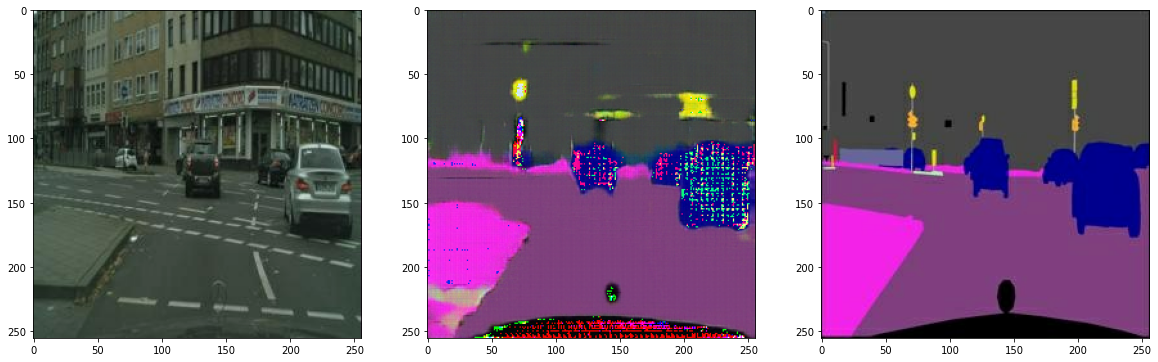

In [21]:
test_ind = 1
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

f = data_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

## 6. 결과

* EPOCHS = 10       
오브젝트의 대략적인 위치만 보임.
* EPOCHS = 100       
간판봉이 퍼져보이는게 아쉽지만, 자동차의 바퀴 모양 등의 구체적인 오브젝트 모습이 생성되고 있어              
전체적으로 실제 사진과 흡사함. 학습횟수가 늘어날수록 좋은 모델 성능을 보임을 알 수 있음         


* Pix2Pix의 U-Net 구조 기반 Generator과 L1+cGAN loss를 사용함
* Data Augmentation는 crop, flip_left_right, flip_up_down 사용함